In [1]:
import numpy as np
import core
import matplotlib.pyplot as plt
import os
import pickle
import visualization
from sklearn.metrics import r2_score
pathway = np.array([
        [70, 0, 30],[0, 65, 35],[-60, 0, 40],[0, -55, 45],
        [50, 0, 50],[0, 45, 55],[-40, 0, 60],[0, -35, 65],
        [30, 0, 70],[0, 25, 75],[-20, 0, 80],[0, -15, 85],
        [10, 0, 90],[0, 5, 95],[0, 0, 100]
    ])
flight=core.create_scene(numCam=3,camera_radius=100,camera_height=0,camera_toward_height=65,pathway=pathway,interp_points_num=300)

# 3D scene visualization

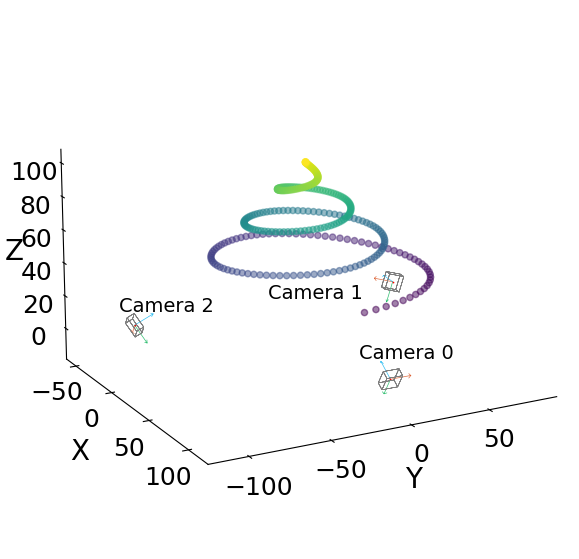

In [3]:
visualization.visualize_simulation_scene(flight,output_file='simulations-scene.pdf', quiver_length=13,linewidth=0.5,elev=18, azim=-28)

# Top view of scene

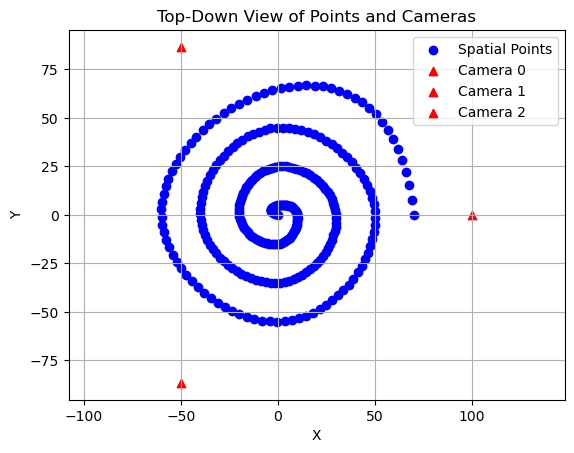

In [4]:
visualization.visualize_top_down_view(flight)

## Projection of space points in camera 0

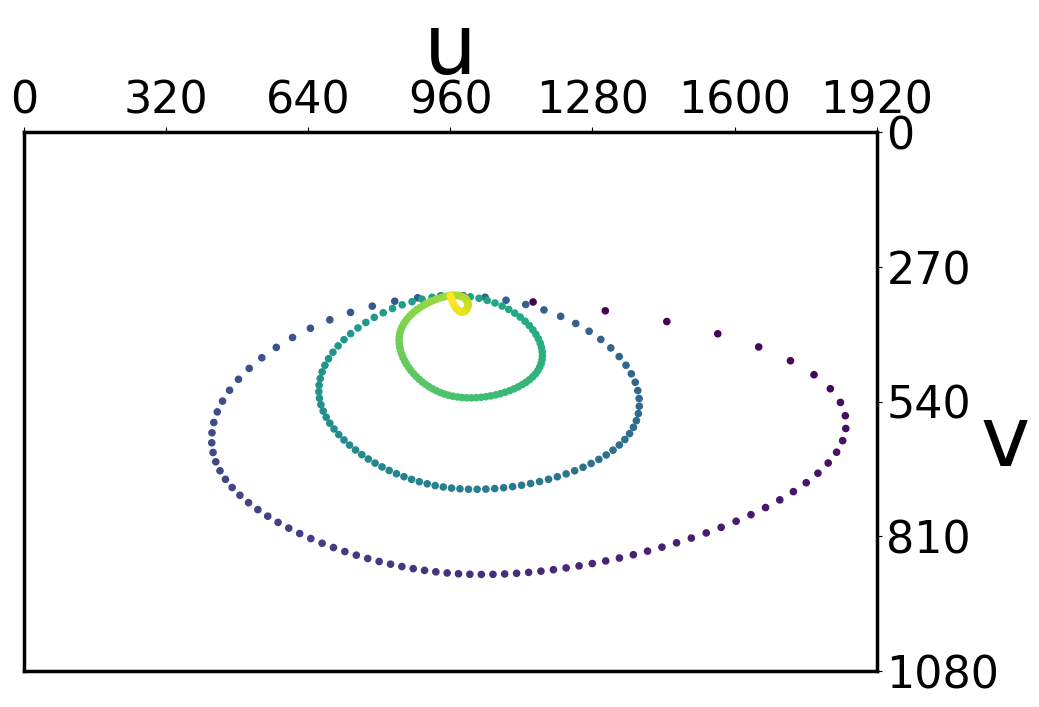

In [5]:
visualization.visualize_camera_projection(flight, camera_id=0,image_width=1920, image_height=1080,marker_size=20,output_file='Projection-of-Spatial-Points-on-Camera-0-Image-Plane.pdf')

# Generation of Initial 3D Trajectory

In [6]:
x1,x2,d1,d2,X = flight.init_traj()

# Integration of Multi-Camera Data

In [7]:
for cameraid in range(2,flight.numCam):
    print(cameraid)
    flight.get_camera_pose(cam_id=cameraid,objectPoints=flight.traj[1:4].T,imagePoints=flight.cameras[cameraid].imagepoints[:,1:])

2


# Calculation of Similarity Transformation Matrix between Camera 0 and World Coordinates

In [8]:
M = core.calculate_similarity_transformation_matrix(flight)
reconstruction_result=np.dot(M,X)[:3]

# 3D visualization of the result

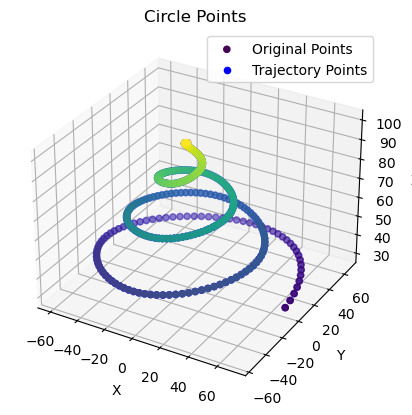

In [9]:
visualization.visualize_3d_trajectory(flight, reconstruction_result)

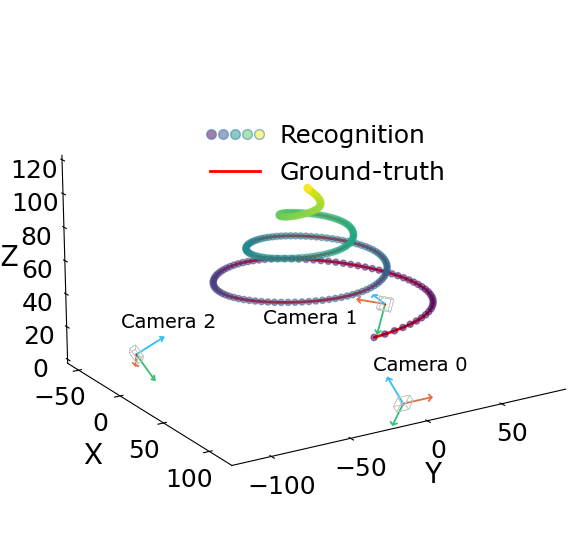

In [10]:
visualization.visualize_simulation_scene_results(flight,reconstruction_result,output_file='simulations-scene.pdf', quiver_length=19,linewidth=1.3,elev=18, azim=-32,result_line_width=2,bbox_to_anchor=(0.8,0.83))

# Metrics

In [12]:
calculated_points=reconstruction_result.T
true_points=flight.points.T
# Calculate Euclidean distances between each pair of corresponding points
euclidean_distances = np.linalg.norm(true_points - calculated_points, axis=1)

# Calculate RMSE based on Euclidean distances
rmse = np.sqrt(np.mean(euclidean_distances**2))

# Calculate MAE based on Euclidean distances
mae = np.mean(euclidean_distances)

# Calculate Maximum Error using Euclidean distances
max_err = np.max(euclidean_distances)

# Calculate R-squared
r_squared = r2_score(true_points, calculated_points)

print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"Maximum Error: {max_err:.5f}")
print(f"R-squared: {r_squared:.5f}")

RMSE: 0.00032
MAE: 0.00032
Maximum Error: 0.00049
R-squared: 1.00000


# The effect of camera positioning error on the result is discussed

In [1]:
def save_results(data, filename):
    with open(filename, 'wb') as f:
        pickle.dump(data, f)

def load_results(filename):
    with open(filename, 'rb') as f:
        return pickle.load(f)

In [15]:
filename = 'camera_position_error.pkl'
error_levels = [0.1, 0.2, 0.4, 0.6, 0.8, 1.0]

if os.path.exists(filename):
    all_error_arrays = load_results(filename)
else:
    p1 = []
    for i in range(flight.numCam):
        p1.append(-np.linalg.inv(flight.cameras[i].R_camera0).dot(np.array(flight.cameras[i].t_camera0)))
    p1 = np.array(p1).T

    all_error_arrays = core.simulate_reconstruction_error_position(flight, p1, X, error_levels=error_levels)
    save_results(all_error_arrays, filename)

In [16]:
all_rmse_lists = []
all_mae_lists = []
all_max_err_lists = []
mean_rmses = []
mean_maes = []
mean_max_errs = []
mean_r_squareds = []
percentile_95_rmses = []

for error_array in all_error_arrays:
    error,error_arr=error_array
    rmse_list = []
    mae_list = []
    max_err_list = []
    r_squared_list=[]
    for time in range(10000):
        calculated_points=flight.points.T+error_arr[time].T
        true_points=flight.points.T
        # Calculate Euclidean distances between each pair of corresponding points
        euclidean_distances = np.linalg.norm(error_arr[time].T, axis=1)
        # Calculate RMSE based on Euclidean distances
        rmse = np.sqrt(np.mean(euclidean_distances**2))
        # Calculate MAE based on Euclidean distances
        mae = np.mean(euclidean_distances)
        # Calculate Maximum Error using Euclidean distances
        max_err = np.max(euclidean_distances)
        r_squared = r2_score(flight.points.T, flight.points.T+error_arr[time].T)

        rmse_list.append(rmse)
        mae_list.append(mae)
        max_err_list.append(max_err)
        r_squared_list.append(r_squared)
    all_rmse_lists.append((error, rmse_list))
    all_mae_lists.append((error, mae_list))
    all_max_err_lists.append((error, max_err_list))
    mean_rmses.append(np.mean(rmse_list))
    mean_maes.append(np.mean(mae_list))
    mean_max_errs.append(np.mean(max_err_list))
    mean_r_squareds.append(np.mean(r_squared_list))
    percentile_95_rmses.append(np.percentile(rmse_list, 95))

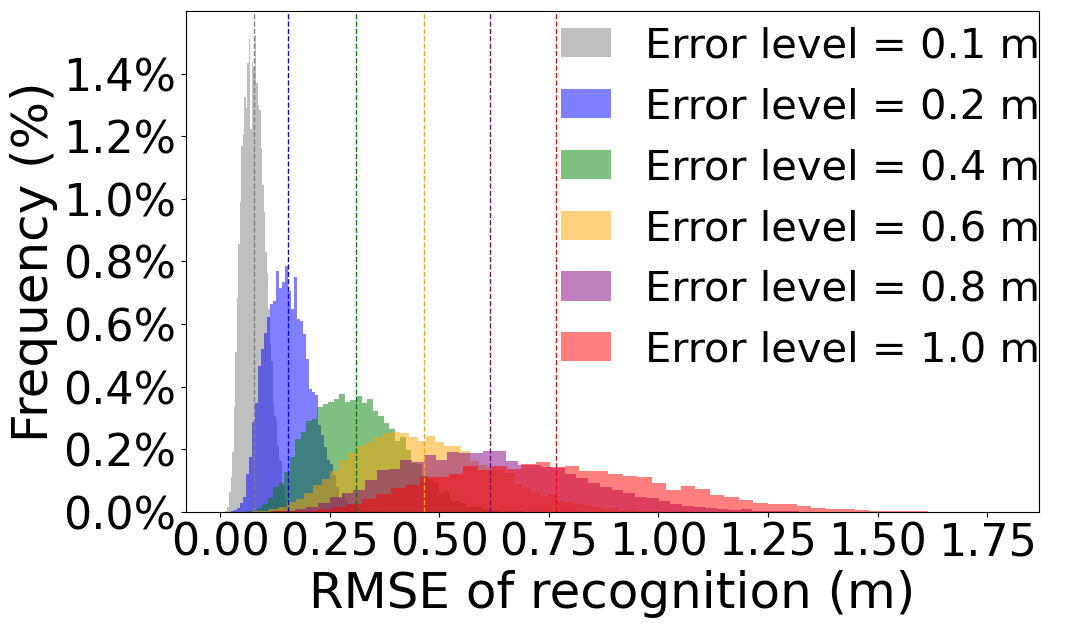

In [17]:
visualization.plot_rmse_distributions(all_rmse_lists, error_type='camera_positioning',title="RMSE", output_file="Reconstruction-Error-camera-positioning-rmse.pdf",bbox_to_anchor=(1.045, 1.045))

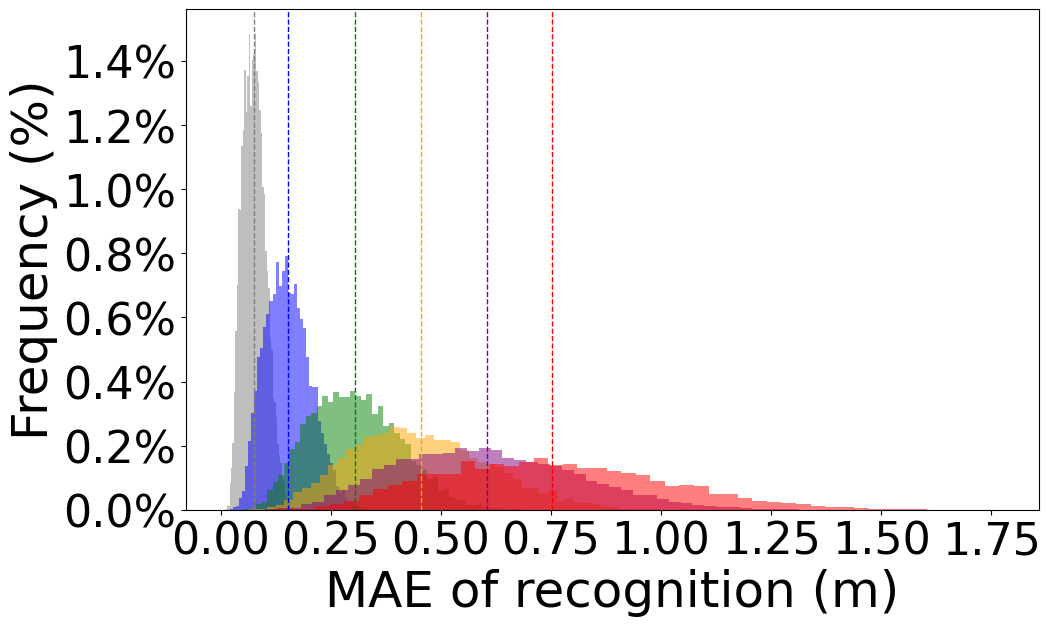

In [18]:
visualization.plot_rmse_distributions(all_mae_lists, error_type='camera_positioning',title="MAE", output_file="Reconstruction-Error-camera-positioning-mae.pdf",legend_show=False)

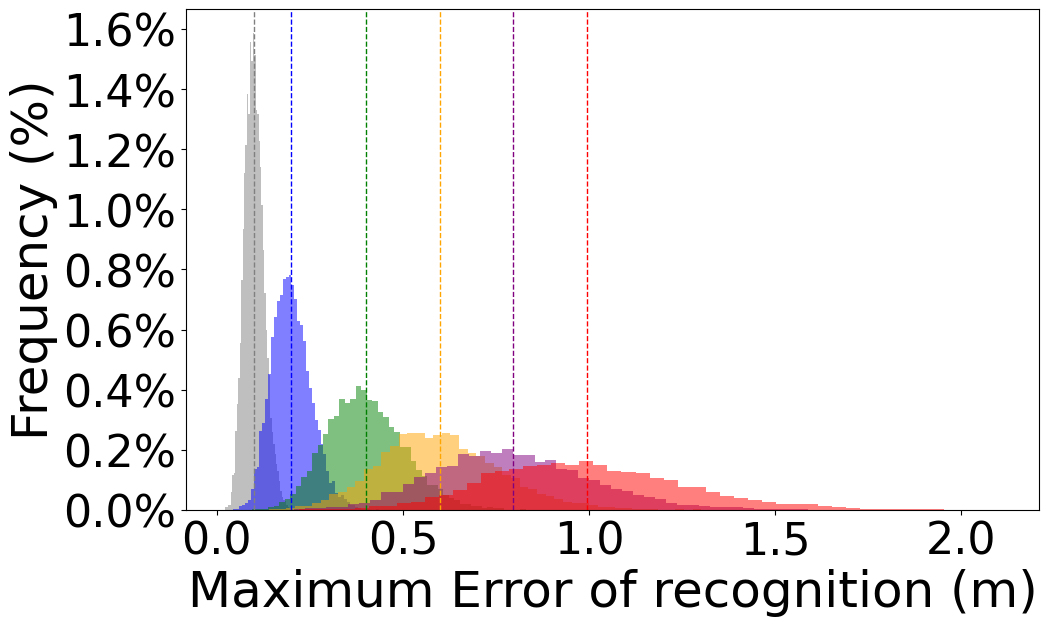

In [19]:
visualization.plot_rmse_distributions(all_max_err_lists, error_type='camera_positioning', title="Maximum Error", output_file="Reconstruction-Error-camera-positioning-max_err.pdf",legend_show=False)

In [20]:
for error, mean_rmse,mean_mae,mean_max_err,mean_r_squared, percentile_95_rmse in zip(error_levels, mean_rmses,mean_maes,mean_max_errs,mean_r_squareds, percentile_95_rmses):
    print(f"Camera positioning error = {error} m")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    print(f"mean_mae: {mean_mae:.4f}")
    print(f"mean_max_err: {mean_max_err:.4f}")
    print(f"mean_r_squared: {mean_r_squared:.4f}")
    print(f"95th percentile RMSE: {percentile_95_rmse:.4f}")

Camera positioning error = 0.1 m
Mean RMSE: 0.0777
mean_mae: 0.0763
mean_max_err: 0.1004
mean_r_squared: 1.0000
95th percentile RMSE: 0.1224
Camera positioning error = 0.2 m
Mean RMSE: 0.1553
mean_mae: 0.1525
mean_max_err: 0.2004
mean_r_squared: 1.0000
95th percentile RMSE: 0.2441
Camera positioning error = 0.4 m
Mean RMSE: 0.3109
mean_mae: 0.3053
mean_max_err: 0.4012
mean_r_squared: 0.9999
95th percentile RMSE: 0.4857
Camera positioning error = 0.6 m
Mean RMSE: 0.4642
mean_mae: 0.4558
mean_max_err: 0.6004
mean_r_squared: 0.9999
95th percentile RMSE: 0.7373
Camera positioning error = 0.8 m
Mean RMSE: 0.6162
mean_mae: 0.6050
mean_max_err: 0.7965
mean_r_squared: 0.9998
95th percentile RMSE: 0.9702
Camera positioning error = 1.0 m
Mean RMSE: 0.7673
mean_mae: 0.7533
mean_max_err: 0.9936
mean_r_squared: 0.9997
95th percentile RMSE: 1.2057


# The effect of camera positioning error on the target detection is discussed

In [22]:
filename = 'target_detection_error.pkl'
error_levels = [1, 2, 4, 6, 8, 10]
if os.path.exists(filename):
    all_error_arrays = load_results(filename)
else:
    all_error_arrays = core.simulate_reconstruction_error_detection(flight,times=10000,error_levels = error_levels)
    save_results(all_error_arrays, filename)

In [23]:
all_rmse_lists = []
all_mae_lists = []
all_max_err_lists = []
mean_rmses = []
mean_maes = []
mean_max_errs = []
mean_r_squareds = []
percentile_95_rmses = []

for error_array in all_error_arrays:
    error,error_arr=error_array
    rmse_list = []
    mae_list = []
    max_err_list = []
    r_squared_list=[]
    for time in range(10000):
        calculated_points=flight.points.T+error_arr[time].T
        true_points=flight.points.T
        # Calculate Euclidean distances between each pair of corresponding points
        euclidean_distances = np.linalg.norm(error_arr[time].T, axis=1)
        # Calculate RMSE based on Euclidean distances
        rmse = np.sqrt(np.mean(euclidean_distances**2))
        # Calculate MAE based on Euclidean distances
        mae = np.mean(euclidean_distances)
        # Calculate Maximum Error using Euclidean distances
        max_err = np.max(euclidean_distances)
        r_squared = r2_score(flight.points.T, flight.points.T+error_arr[time].T)

        rmse_list.append(rmse)
        mae_list.append(mae)
        max_err_list.append(max_err)
        r_squared_list.append(r_squared)
    all_rmse_lists.append((error, rmse_list))
    all_mae_lists.append((error, mae_list))
    all_max_err_lists.append((error, max_err_list))
    mean_rmses.append(np.mean(rmse_list))
    mean_maes.append(np.mean(mae_list))
    mean_max_errs.append(np.mean(max_err_list))
    mean_r_squareds.append(np.mean(r_squared_list))
    percentile_95_rmses.append(np.percentile(rmse_list, 95))

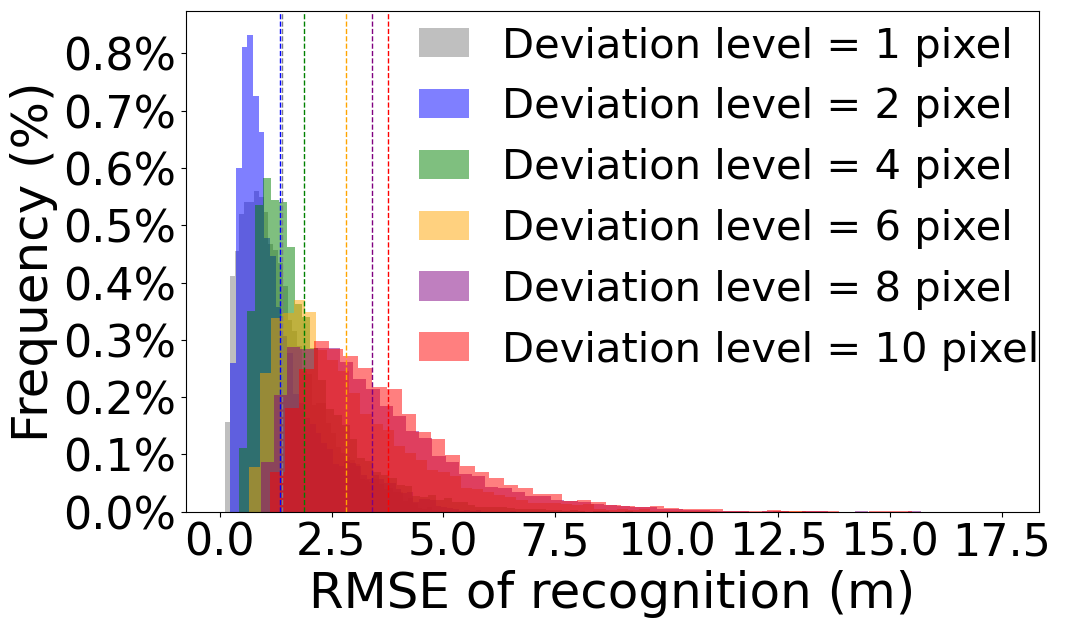

In [24]:
visualization.plot_rmse_distributions(all_rmse_lists,error_type='detection', title="RMSE", output_file="Reconstruction-Error-detection-rmse.pdf",bbox_to_anchor=(1.045, 1.045))

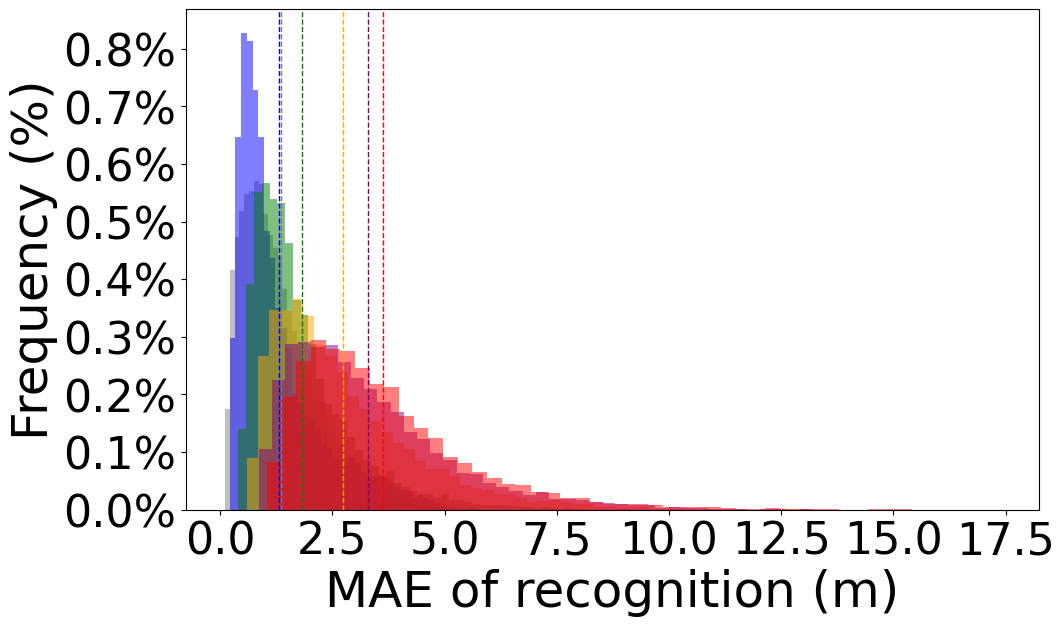

In [25]:
visualization.plot_rmse_distributions(all_mae_lists,error_type='detection',title="MAE", output_file="Reconstruction-Error-detection-mae.pdf",legend_show=False)

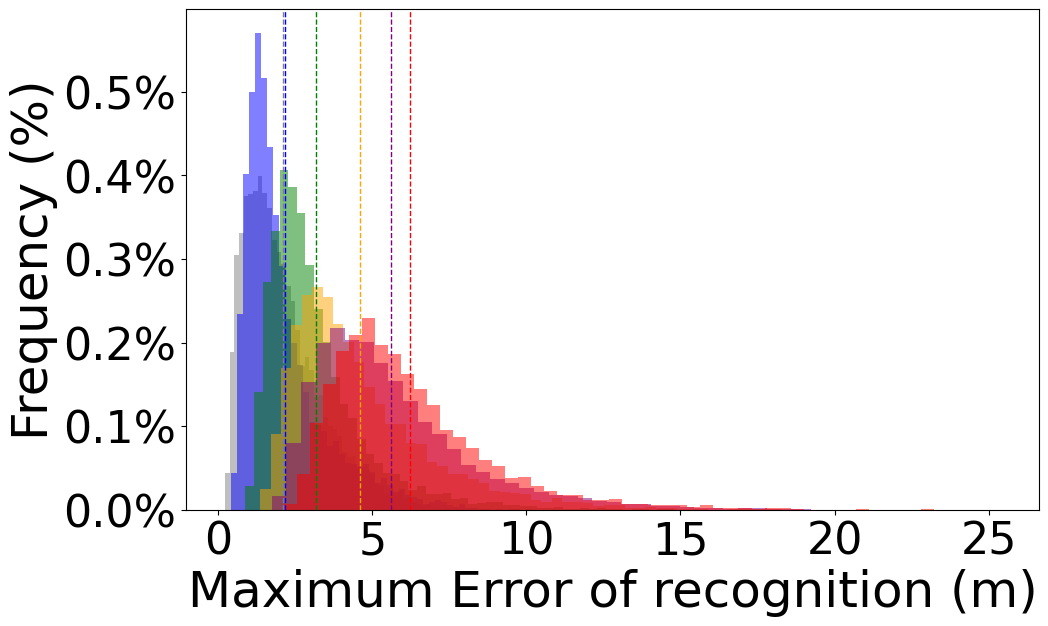

In [26]:
visualization.plot_rmse_distributions(all_max_err_lists,error_type='detection',title="Maximum Error", output_file="Reconstruction-Error-detection-max_err.pdf",legend_show=False)

In [27]:
for error, mean_rmse,mean_mae,mean_max_err,mean_r_squared, percentile_95_rmse in zip(error_levels, mean_rmses,mean_maes,mean_max_errs,mean_r_squareds, percentile_95_rmses):
    print(f"Camera positioning error = {error} m")
    print(f"Mean RMSE: {mean_rmse:.4f}")
    print(f"mean_mae: {mean_mae:.4f}")
    print(f"mean_max_err: {mean_max_err:.4f}")
    print(f"mean_r_squared: {mean_r_squared:.4f}")
    print(f"95th percentile RMSE: {percentile_95_rmse:.4f}")

Camera positioning error = 1 m
Mean RMSE: 1.3811
mean_mae: 1.3545
mean_max_err: 2.0960
mean_r_squared: 0.9988
95th percentile RMSE: 3.2131
Camera positioning error = 2 m
Mean RMSE: 1.3465
mean_mae: 1.3115
mean_max_err: 2.1552
mean_r_squared: 0.9987
95th percentile RMSE: 3.5384
Camera positioning error = 4 m
Mean RMSE: 1.8805
mean_mae: 1.8195
mean_max_err: 3.1625
mean_r_squared: 0.9977
95th percentile RMSE: 4.1532
Camera positioning error = 6 m
Mean RMSE: 2.8155
mean_mae: 2.7303
mean_max_err: 4.6152
mean_r_squared: 0.9951
95th percentile RMSE: 6.0570
Camera positioning error = 8 m
Mean RMSE: 3.4120
mean_mae: 3.3034
mean_max_err: 5.6120
mean_r_squared: 0.9930
95th percentile RMSE: 7.0754
Camera positioning error = 10 m
Mean RMSE: 3.7553
mean_mae: 3.6272
mean_max_err: 6.2098
mean_r_squared: 0.9917
95th percentile RMSE: 7.4387


# scaling

In [29]:
filename = 'size_ratio_error.pkl'
size_ratio=[0.25,0.5,1,1.5,2]
if os.path.exists(filename):
    all_error_arrays = load_results(filename)
else:
    all_error_arrays = core.simulate_reconstruction_error_size(times=10000,pixel_error=3,position_error=0.2, size_ratio=size_ratio)
    save_results(all_error_arrays, filename)

In [30]:
all_rmse_lists = []
all_mae_lists = []
all_max_err_lists = []
mean_rmses = []
mean_maes = []
mean_max_errs = []
mean_r_squareds = []
percentile_95_rmses = []

for error_array in all_error_arrays:
    error,error_arr=error_array
    rmse_list = []
    mae_list = []
    max_err_list = []
    r_squared_list=[]
    for time in range(10000):
        calculated_points=flight.points.T+error_arr[time].T
        true_points=flight.points.T
        # Calculate Euclidean distances between each pair of corresponding points
        euclidean_distances = np.linalg.norm(error_arr[time].T, axis=1)
        # Calculate RMSE based on Euclidean distances
        rmse = np.sqrt(np.mean(euclidean_distances**2))
        # Calculate MAE based on Euclidean distances
        mae = np.mean(euclidean_distances)
        # Calculate Maximum Error using Euclidean distances
        max_err = np.max(euclidean_distances)
        r_squared = r2_score(flight.points.T, flight.points.T+error_arr[time].T)

        rmse_list.append(rmse)
        mae_list.append(mae)
        max_err_list.append(max_err)
        r_squared_list.append(r_squared)
    all_rmse_lists.append((error, rmse_list))
    all_mae_lists.append((error, mae_list))
    all_max_err_lists.append((error, max_err_list))
    mean_rmses.append(np.mean(rmse_list))
    mean_maes.append(np.mean(mae_list))
    mean_max_errs.append(np.mean(max_err_list))
    mean_r_squareds.append(np.mean(r_squared_list))
    percentile_95_rmses.append(np.percentile(rmse_list, 95))

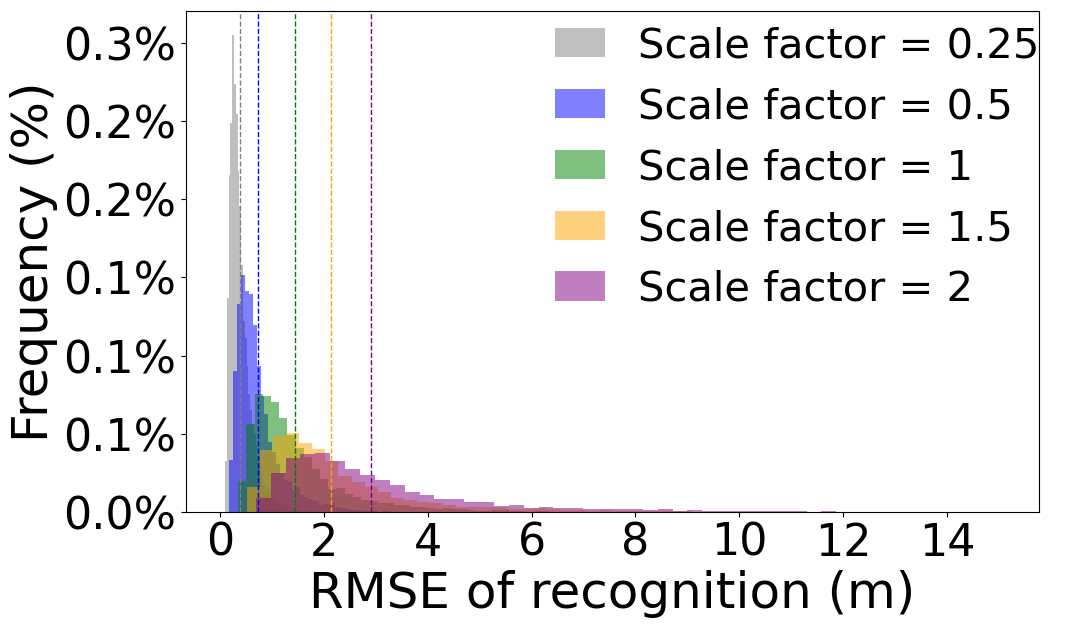

In [31]:
visualization.plot_rmse_distributions(all_rmse_lists,error_type='size_ratio',title="RMSE", output_file="Reconstruction-Error-size-ratio-rmse.pdf",bbox_to_anchor=(1.045, 1.045))

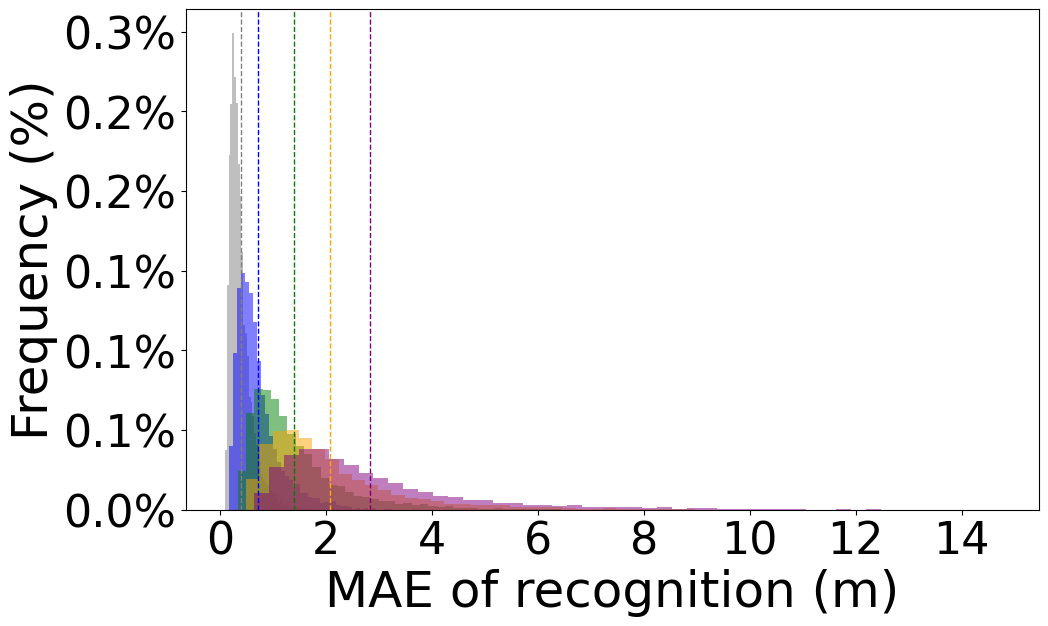

In [32]:
visualization.plot_rmse_distributions(all_mae_lists,error_type='size_ratio',title="MAE", output_file="Reconstruction-Error-size-ratio-mae.pdf",legend_show=False)

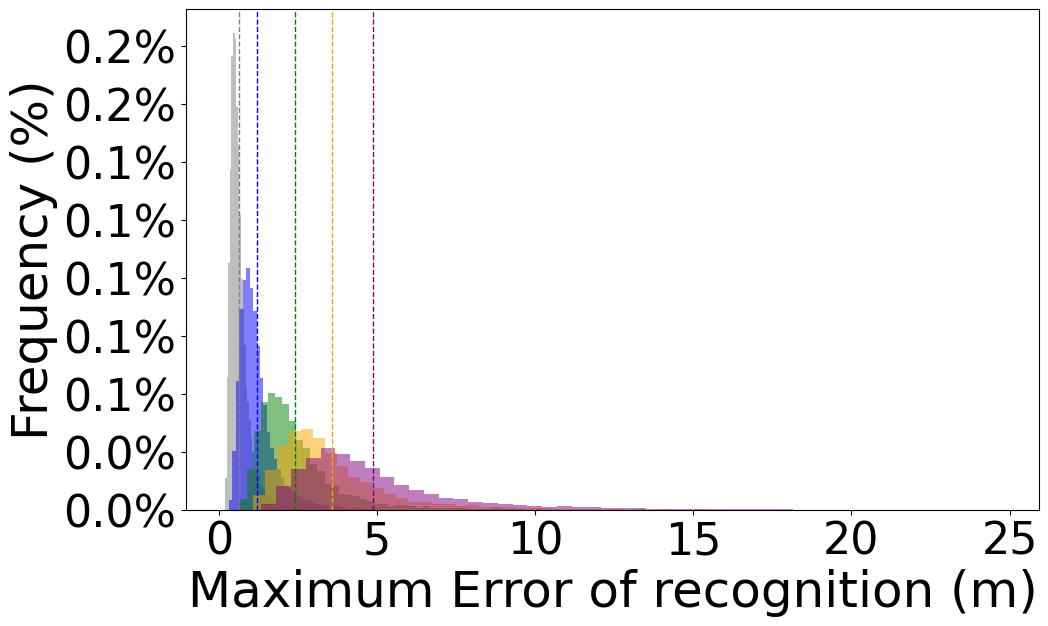

In [33]:
visualization.plot_rmse_distributions(all_max_err_lists,error_type='size_ratio',title="Maximum Error", output_file="Reconstruction-Error-size-ratio-max_err.pdf",legend_show=False)

In [34]:
for error, mean_rmse,mean_mae,mean_max_err,mean_r_squared, percentile_95_rmse in zip(error_levels, mean_rmses,mean_maes,mean_max_errs,mean_r_squareds, percentile_95_rmses):
    print(f"Mean RMSE: {mean_rmse:.4f}")
    print(f"mean_mae: {mean_mae:.4f}")
    print(f"mean_max_err: {mean_max_err:.4f}")
    print(f"mean_r_squared: {mean_r_squared:.4f}")
    print(f"95th percentile RMSE: {percentile_95_rmse:.4f}")

Mean RMSE: 0.3942
mean_mae: 0.3829
mean_max_err: 0.6415
mean_r_squared: 0.9999
95th percentile RMSE: 0.8242
Mean RMSE: 0.7316
mean_mae: 0.7088
mean_max_err: 1.2189
mean_r_squared: 0.9997
95th percentile RMSE: 1.6217
Mean RMSE: 1.4404
mean_mae: 1.3940
mean_max_err: 2.4168
mean_r_squared: 0.9986
95th percentile RMSE: 3.2663
Mean RMSE: 2.1382
mean_mae: 2.0694
mean_max_err: 3.5901
mean_r_squared: 0.9970
95th percentile RMSE: 4.8610
Mean RMSE: 2.9114
mean_mae: 2.8185
mean_max_err: 4.8698
mean_r_squared: 0.9944
95th percentile RMSE: 6.6647
